# Roll Your Own Analysis

This notebook will demonstrate how to download raw data from the ENPA REST API, debias it, and display a basic visualization by performing the following actions:

1. <a href="#Downloading-Raw-ENPA-Data">Downloading raw ENPA data</a>, 
2. <a href="#Debiasing-Raw-Data">Debiasing raw data</a>, and 
3. <a href="#Visualizing-the-Debiased-Data">Visualizing the debiased data</a>.

Be sure to have your full API key ready before proceeding.

## Downloading Raw ENPA Data

This section will describe how to download raw ENPA data to perform further analysis using your full API key. Begin by following the steps below.

1) Navigate to the *API Docs* tab within the ENPA portal, and select *Authorize*.

![Step4](https://raw.githubusercontent.com/c19hcc/enpa-pha-jupyternotebooks/main/images/Step4.png)

2) Input your *Full Key* into the dialog box and select *Authorize*. Note, the full API key must be included as an `X-Api-Key` header in all requests.

![Step5W](https://raw.githubusercontent.com/c19hcc/enpa-pha-jupyternotebooks/main/images/Step5W.png)

3) Import Python's Request library and construct the necessary header to include the API key.

In [1]:
import requests

header = {"X-Api-Key": "605e7459-4d10-4177-8d36-7e03abbb6599.df11573319c7636e77f6d88ca887d6e5e64f6f43f72af12527f1e72efa4f4098"}

4) Specify parameters and request the desired data.
* `datasets`: Choose from one of six datasets to download :`notification`, `notificationInteractions`, `riskParameters`, `codeVerified`, `keysUploaded`, or `beaconCount`.
* `raw`: Specify `True` to return the raw, biased data or `False` to return the debiased data.
* `start_date`: Specify a start date to download data (must be in YYYY-MM-DD format); if omitted, the default is 90 days before either the end date (if specified) or the current date.
* `end_date`: Specify an end date to download data (must be in YYYY-MM-DD format); if omitted, the default is the current date. 
* `country`: Input an ISO 3166-1 code for the country (e.g., `US`).
* `state`: Input an ISO-3166-2 code for the subdivision, state, or province (e.g., `US-VA`).

In [2]:
parameters = {
    "datasets": "notification",
    "raw": True,
    "start_date": "2022-01-01",
    "end_date": "2022-01-31",
    "country": "US",
    "state": "US-MD"
}

In [3]:
notificationRequest = requests.get("https://api.enpa-pha.io/api/public/v2/enpa-data",
                      headers = header, params = parameters)
print("Reason: ", notificationRequest.reason, "\nStatus Code: ", notificationRequest.status_code)

Reason:  OK 
Status Code:  200


A *Status Code* of 200 indicates that the data was successfully retrieved!

## Debiasing Raw Data

This section will describe how to prepare and debias the raw data downloaded from ENPA's REST API. Begin by following the steps below.

1) Convert the downloaded data from string to dictionary form using the `json` library, so it can be easy manipulated.

In [4]:
import json
convertedNotifications = json.loads(notificationRequest.text)

Here is what the data look like. Let's try to visualize total number of notifications over time as a stacked bar chart indicating iOS and Android notifications.

In [5]:
convertedNotifications

{'dataType': 'base',
 'genericID': 'notification',
 'uiLabel': 'Notifications',
 'appleID': 'com.apple.EN.UserNotification',
 'googleID': 'PeriodicExposureNotification',
 'startDate': '2022-01-01',
 'endDate': '2022-01-31',
 'countryCode': 'US',
 'subdivisionCode': 'MD',
 'numberRollingDayAverage': 1,
 'totalClients': {},
 'metricData': [],
 'rawData': [{'id': 'sum-apple-com.apple.EN.UserNotification-us-md-b989d95ba89c163aa9917b598ffc2616816079b3e282a0d191a841fe38d89b9f-202201010000-202201010800',
   'sum': [108685, 337, 33, 42, 37],
   'aggregation_start_time': '2022-01-01T00:00:00.000Z',
   'aggregation_end_time': '2022-01-01T08:00:00.000Z',
   'generic_id': 'notification',
   'aggregation_id': 'com.apple.EN.UserNotification',
   'subdivision_code': 'md',
   'country_code': 'us',
   'data_provider': 'apple',
   'provider_version': 'b989d95ba89c163aa9917b598ffc2616816079b3e282a0d191a841fe38d89b9f',
   'epsilon': 8,
   'hamming_weight': None,
   'total_individual_clients': 109015},
  {

2) Crawling through the dictionary structure, we need to find the `totalCount`, the total number of clients (`total_individual_clients`); `sum`, the sum value (sum of an individual element of the `sum` array(s)); and `epsilon`, the epsilon from the raw value. These values are needed to debias the data. Here is what the debias function looks like.

In [6]:
import math

def getMostLikelyPopulationCount(totalCount, sumPart, epsilon):
    '''
    Debiases raw sum values (`sumPart`).
    
    :param totalCount: The total number of clients (`total_individual_clients`)
    :param sumPart: The sum value (sum of an individual element of the `sum` array(s))
    :param epsilon: Epsilon from the raw value
    :return: 
        - `mostLikelyPopulation` (float): The debiased (expected) value
        - `standardDeviation` (float): Standard deviation
    '''
    p = 1 / (1 + math.exp(epsilon))
    sqrtPTimesOneMinusP = math.exp(epsilon / 2) / (1 + math.exp(epsilon))
    mostLikelyPopulation = (sumPart - totalCount * p) / (1 - 2 * p)
    standardDeviation = math.sqrt(totalCount) * sqrtPTimesOneMinusP
    return mostLikelyPopulation, standardDeviation

In [7]:
getMostLikelyPopulationCount(109015, sum([108685, 337, 33, 42, 37]), 8)

(109170.66259741751, 6.045323372452216)

In [8]:
convertedNotifications['rawData'][0]['sum'][1]

337

We will call `getMostLikelyPopulationCount`, the debiasing function, when it is time to prepare the data for visualization.

## Visualizing the Debiased Data

This section will describe how to prepare and visualize the raw data downloaded from ENPA's REST API. Begin by following the steps below.

1) Run `makeStackedBar` to prepare the data for visualization. First, iterate through all records to debias the raw data using the debiasing function, `getMostLikelyPopulationCount`. For the purposes of constructing a stacked bar, iOS and Android data are being processed seperately. Second, place the notification counts with their respective dates. Then, group the notifications by day. There are initially several entries for each day (e.g., 02/01/2022 0:00-8:00, 02/01/2022 8:00-16:00, 02/01/2022 16:00-0:00, ...), so this grouping will allow for easy comparison across different days (you can change this if you choose).

In [13]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

def makeStackedBar(data):
    '''
    Prepares and visualizes data. Note that this function calls the debias function, getMostLikelyPopulationCount
    
    :param data: A raw dataset in JSON form
    :prints: 
        - Stacked bar illustrating the total number of notifications
    '''
    datesApple = []
    datesGoogle = []
    notificationsApple = []
    notificationsGoogle = []
    
    for i in range(len(convertedNotifications['rawData'])):
        
        # Debiasing Apple/iOS Data
        if(convertedNotifications['rawData'][i]['aggregation_id'] == "com.apple.EN.UserNotification"):
            datesApple.append(datetime.strptime(convertedNotifications['rawData'][i]['aggregation_start_time'][0:10], "%Y-%m-%d"))
            totalCount = convertedNotifications['rawData'][i]['total_individual_clients'] # totalCount parameter for debiasing
            sumPart = convertedNotifications['rawData'][i]['sum'][1] # sumPart parameter for debiasing
            epsilon = convertedNotifications['rawData'][i]['epsilon'] # epsilon parameter for debiasing
            # Call debiasing function
            (mostLikelyNotifications, standardDeviation) = getMostLikelyPopulationCount(totalCount, sumPart, epsilon)
            notificationsApple.append(mostLikelyNotifications)
            
        # Debiasing Google/Android Data
        elif(convertedNotifications['rawData'][i]['aggregation_id'] == "PeriodicExposureNotification"):
            datesGoogle.append(datetime.strptime(convertedNotifications['rawData'][i]['aggregation_start_time'][0:10], "%Y-%m-%d"))
            totalCount = convertedNotifications['rawData'][i]['total_individual_clients'] # totalCount parameter for debiasing
            sumPart = convertedNotifications['rawData'][i]['sum'][1] # sumPart parameter for debiasing
            epsilon = convertedNotifications['rawData'][i]['epsilon'] # epsilon parameter for debiasing
            # Call debiasing function
            (mostLikelyNotifications, standardDeviation) = getMostLikelyPopulationCount(totalCount, sumPart, epsilon)
            notificationsGoogle.append(mostLikelyNotifications)
            
    # Place notification counts with their respective dates
    AppleData = pd.DataFrame(list(zip(datesApple, notificationsApple)), columns = ['Date', 'Apple Notifications'])
    GoogleData = pd.DataFrame(list(zip(datesGoogle, notificationsGoogle)), columns = ['Date', 'Google Notifications'])
    
    # Sum notifications in different time intervals during the same day; join Apple and Google data
    AppleGrouping = AppleData.groupby(['Date'])['Apple Notifications'].sum()
    GoogleGrouping = GoogleData.groupby(['Date'])['Google Notifications'].sum()
    AppleDF = pd.DataFrame(AppleGrouping.reset_index())
    GoogleDF = pd.DataFrame(GoogleGrouping.reset_index())
    CombinedData = AppleDF.merge(GoogleDF, on = 'Date', how = 'left')
    
    # Plotting a Stacked Bar
    plt.figure(figsize=(15, 8))
    plt.rcParams.update({'font.size': 16})
    barWidth = 0.6
    plt.bar(CombinedData['Date'], CombinedData['Apple Notifications'], barWidth, label = 'iOS')
    plt.bar(CombinedData['Date'], CombinedData['Google Notifications'], barWidth, label = 'Android', bottom=CombinedData['Apple Notifications'])
    plt.legend()
    plt.xticks(rotation=45)
    plt.xlabel("Date")
    plt.ylabel("Number of Notifications")
    plt.title("Total Notifications Over Time")
   

    # Delete this before uploading
    print(CombinedData['Apple Notifications'][14] + CombinedData['Google Notifications'][14])

2) Run the `makeStackedBar` function to debias, organize, and plot the notification data.

1627.787970231813


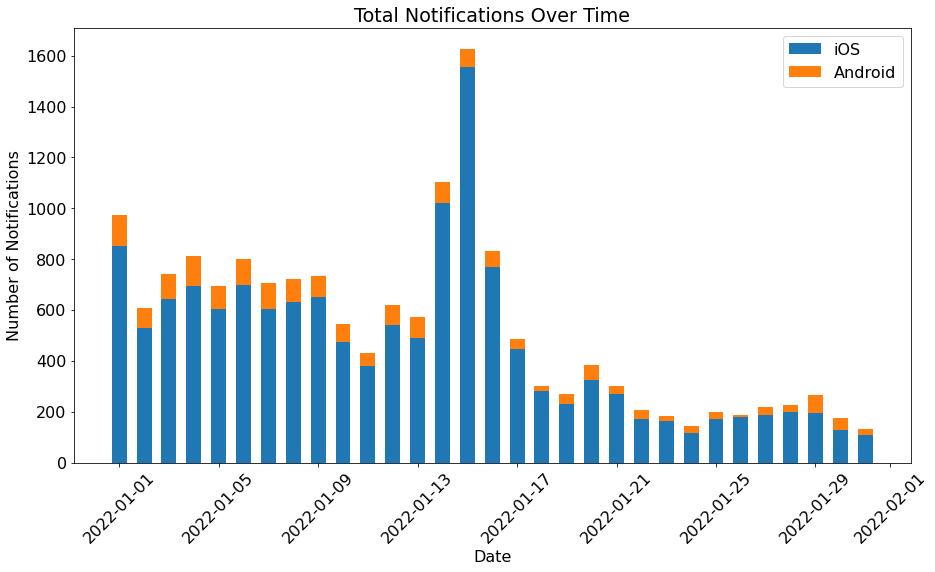

In [14]:
makeStackedBar(convertedNotifications)